In [ ]:
#Домашнее задание по лекции "Современные сверточные архитектуры" DLL-2

Основное задание
Возьмите датасет https://www.kaggle.com/ajayrana/hymenoptera-data/kernels
1.Обучите на нем модели ResNet 18 и VGG 16 с нуля (5-10 эпох)
2.Обучите на нем модели ResNet 18 и VGG 16 с использованием FineTuning (5-10 эпох)
3.Добавьте аугментацию данных к пункту 2

Сравните качество всех 3 полученных подходов

Задание со звездочкой
Примените FineTuning ResNet 18 к FashionMnist. Удалось ли увидеть резкое увеличение качества?

In [ ]:
#https://www.kaggle.com/mnagao/pytorch-hymenoptera
#!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
import albumentations as A
import cv2
import pandas as pd

In [3]:
#import GPUtil

In [4]:
#GPUtil.showUtilization()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
root_path = 'gdrive/My Drive/data_science/hymenoptera-data/'
#root_path = 'C:/Users/zamarseny/Documents/data_science/DL2/DL_2-master/hymenoptera_data'
#for i in os.listdir(root_path):
#  print(i)

In [12]:
!cd drive/
!cd 'drive/My Drive'
!cd /content/gdrive/MyDrive/data_science/hymenoptera_data
#cd data_science/
#cd hymenoptera_data/
#!cd C:/Users/zamarseny/Documents/data_science/DL2/DL_2-master/hymenoptera_data

/bin/bash: line 0: cd: drive/: No such file or directory
/bin/bash: line 0: cd: drive/My Drive: No such file or directory


In [13]:
!ls

gdrive	sample_data


In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/data_science/hymenoptera_data/hymenoptera_data'
#data_dir='C:/Users/zamarseny/Documents/data_science/DL2/DL_2-master/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes



In [15]:
class_names

['ants', 'bees']

torch.Size([4, 3, 224, 224])


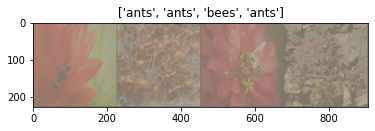

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
#Training the model

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
#model_ft = models.resnet18(pretrained=True)
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = torch.optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.8976 Acc: 0.5533
val Loss: 0.9842 Acc: 0.5163

Epoch 1/9
----------
train Loss: 0.7081 Acc: 0.5615
val Loss: 0.9851 Acc: 0.5490

Epoch 2/9
----------
train Loss: 0.6751 Acc: 0.5902
val Loss: 0.6563 Acc: 0.5752

Epoch 3/9
----------
train Loss: 0.6941 Acc: 0.5861
val Loss: 1.0699 Acc: 0.4575

Epoch 4/9
----------
train Loss: 0.7032 Acc: 0.5738
val Loss: 0.5426 Acc: 0.6928

Epoch 5/9
----------
train Loss: 0.6991 Acc: 0.5779
val Loss: 0.6488 Acc: 0.6275

Epoch 6/9
----------
train Loss: 0.6331 Acc: 0.6434
val Loss: 0.5827 Acc: 0.6405

Epoch 7/9
----------
train Loss: 0.6319 Acc: 0.6639
val Loss: 0.5815 Acc: 0.6405

Epoch 8/9
----------
train Loss: 0.5892 Acc: 0.6803
val Loss: 0.5621 Acc: 0.6928

Epoch 9/9
----------
train Loss: 0.6036 Acc: 0.6844
val Loss: 0.5918 Acc: 0.6797

Training complete in 1m 2s
Best val Acc: 0.692810


In [23]:
device, best_acc.item()

(device(type='cuda', index=0), 0.6928104575163399)

In [24]:
st=str(model_ft)
st=st.split('(')[0]
st

'ResNet'

In [25]:
df=pd.DataFrame(data=None, columns=['dataset','model', 'pretrained', 'augumentations', 'num_epochs','best_val_acc'])

In [26]:
df.loc[0]=['hymenoptera_data', str(model_ft).split('(')[0], False, 'no_augs', 10, best_acc.item()]

In [27]:
df

,dataset,model,pretrained,augumentations,num_epochs,best_val_acc
0,hymenoptera_data,ResNet,False,no_augs,10,0.69281


In [28]:
del model_ft

In [29]:
model_ft = models.vgg16(pretrained=False)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_ft.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [31]:
#torch.cuda.empty_cache()
#GPUtil.showUtilization()

In [32]:
model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 4.6949 Acc: 0.4795
val Loss: 0.7035 Acc: 0.5425

Epoch 1/9
----------
train Loss: 0.7255 Acc: 0.5082
val Loss: 0.6987 Acc: 0.5425

Epoch 2/9
----------
train Loss: 0.7294 Acc: 0.5000
val Loss: 0.6969 Acc: 0.4575

Epoch 3/9
----------
train Loss: 0.7190 Acc: 0.5656
val Loss: 0.7317 Acc: 0.4575

Epoch 4/9
----------
train Loss: 0.7215 Acc: 0.5041
val Loss: 0.6994 Acc: 0.4575

Epoch 5/9
----------
train Loss: 0.7398 Acc: 0.4139
val Loss: 0.6957 Acc: 0.5425

Epoch 6/9
----------
train Loss: 0.7113 Acc: 0.4754
val Loss: 0.6922 Acc: 0.5425

Epoch 7/9
----------
train Loss: 0.6990 Acc: 0.5369
val Loss: 0.6913 Acc: 0.5425

Epoch 8/9
----------
train Loss: 0.7035 Acc: 0.5000
val Loss: 0.6940 Acc: 0.4575

Epoch 9/9
----------
train Loss: 0.7026 Acc: 0.4631
val Loss: 0.6941 Acc: 0.4575

Training complete in 1m 42s
Best val Acc: 0.542484


In [33]:
str(model_ft).split('(')[0]

'VGG'

In [34]:
df.loc[1]=['hymenoptera_data', str(model_ft).split('(')[0], False, 'no_augs', 10, best_acc.item()]

In [35]:
df

,dataset,model,pretrained,augumentations,num_epochs,best_val_acc
0,hymenoptera_data,ResNet,False,no_augs,10,0.692810
1,hymenoptera_data,VGG,False,no_augs,10,0.542484


Augumentations


In [36]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize((224,224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = '../input/hymenoptera-data/hymenoptera_data/hymenoptera_data'
data_dir='/content/gdrive/My Drive/data_science/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
'''
data_transforms = {
    'train': A.Compose([
        A.HueSaturationValue(\
                         hue_shift_limit=0.2, \
                         sat_shift_limit=0.2, \
                         val_shift_limit=0.3, \
                         p=0.1),
        A.OneOf([
            #MotionBlur(p=0.8),
            A.MedianBlur(blur_limit=5, p=0.1),
            A.Blur(blur_limit=8, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=25, p=0.3),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.OpticalDistortion(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        A.RandomCrop(height=200, width=200, p=0.25),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
      'val': A.Compose([
        A.Resize(224,224),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        A.ToTensor(num_classes=1, sigmoid=True, normalize=None)
        #A.pytorch.transforms.ToTensorV2()
    ]),
}
'''

"\ndata_transforms = {\n    'train': A.Compose([\n        A.HueSaturationValue(                         hue_shift_limit=0.2,                          sat_shift_limit=0.2,                          val_shift_limit=0.3,                          p=0.1),\n        A.OneOf([\n            #MotionBlur(p=0.8),\n            A.MedianBlur(blur_limit=5, p=0.1),\n            A.Blur(blur_limit=8, p=0.1),\n        ], p=0.2),\n        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=25, p=0.3),\n        A.HorizontalFlip(p=0.5),\n        A.VerticalFlip(p=0.2),\n        A.OpticalDistortion(p=0.3),\n        A.RandomBrightnessContrast(p=0.3),\n        A.RandomCrop(height=200, width=200, p=0.25),\n        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n        ]),\n      'val': A.Compose([\n        A.Resize(224,224),\n        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),\n        A.ToTensor(num_classes=1, sigmoid=True, normalize=None)\n        #A.pytorch.transforms

In [37]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
#for L in model_ft:
#  L.requires_grad = False
model_ft.requires_grad=False

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = torch.optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.0184 Acc: 0.5205
val Loss: 0.8232 Acc: 0.5817

Epoch 1/9
----------
train Loss: 0.6957 Acc: 0.5738
val Loss: 0.6536 Acc: 0.6732

Epoch 2/9
----------
train Loss: 0.7445 Acc: 0.5492
val Loss: 0.8920 Acc: 0.5163

Epoch 3/9
----------
train Loss: 0.6790 Acc: 0.5943
val Loss: 0.6936 Acc: 0.5686

Epoch 4/9
----------
train Loss: 0.6837 Acc: 0.5902
val Loss: 0.7262 Acc: 0.6078

Epoch 5/9
----------
train Loss: 0.6875 Acc: 0.6311
val Loss: 0.6851 Acc: 0.6471

Epoch 6/9
----------
train Loss: 0.7029 Acc: 0.5615
val Loss: 0.6400 Acc: 0.6667

Epoch 7/9
----------
train Loss: 0.6591 Acc: 0.5861
val Loss: 0.6155 Acc: 0.6993

Epoch 8/9
----------
train Loss: 0.6416 Acc: 0.6311
val Loss: 0.5792 Acc: 0.6667

Epoch 9/9
----------
train Loss: 0.5933 Acc: 0.6516
val Loss: 0.5732 Acc: 0.7190

Training complete in 1m 0s
Best val Acc: 0.718954


In [38]:
df.loc[2]=['hymenoptera_data', str(model_ft).split('(')[0], True, 'simple_augs', 10, best_acc.item()]

In [39]:
df

,dataset,model,pretrained,augumentations,num_epochs,best_val_acc
0,hymenoptera_data,ResNet,False,no_augs,10,0.692810
1,hymenoptera_data,VGG,False,no_augs,10,0.542484
2,hymenoptera_data,ResNet,True,simple_augs,10,0.718954


In [40]:
#ПОКА НЕ НАШЕЛ КАК у VGG16 ЗАМОРОЗИТЬ слои извлекающие фичи и заменить классификационную голову
model_ft = models.vgg16(pretrained=True)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_ft.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [41]:
#ЗАПУСТИЛ 15 ЭПОХ, чтобы увидеть точность больше 0.5. Обучение не всегда идет в этой конфигурации
model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.8993 Acc: 0.4262
val Loss: 1.5884 Acc: 0.4641

Epoch 1/14
----------
train Loss: 0.9941 Acc: 0.5000
val Loss: 0.7161 Acc: 0.4575

Epoch 2/14
----------
train Loss: 0.7508 Acc: 0.4795
val Loss: 0.7048 Acc: 0.5425

Epoch 3/14
----------
train Loss: 0.7543 Acc: 0.5123
val Loss: 0.7854 Acc: 0.4575

Epoch 4/14
----------
train Loss: 0.7111 Acc: 0.5328
val Loss: 0.6896 Acc: 0.5556

Epoch 5/14
----------
train Loss: 0.7310 Acc: 0.4713
val Loss: 0.6869 Acc: 0.5556

Epoch 6/14
----------
train Loss: 0.6370 Acc: 0.6475
val Loss: 0.6347 Acc: 0.6078

Epoch 7/14
----------
train Loss: 0.6646 Acc: 0.6352
val Loss: 0.6423 Acc: 0.6340

Epoch 8/14
----------
train Loss: 0.6180 Acc: 0.6598
val Loss: 0.6120 Acc: 0.6471

Epoch 9/14
----------
train Loss: 0.6230 Acc: 0.6803
val Loss: 0.6443 Acc: 0.6275

Epoch 10/14
----------
train Loss: 0.6054 Acc: 0.6639
val Loss: 0.5521 Acc: 0.7190

Epoch 11/14
----------
train Loss: 0.5742 Acc: 0.7254
val Loss: 0.5752 Acc: 0.6928

Epoch 12/14
----------
t

In [42]:
df.loc[3]=['hymenoptera_data', str(model_ft).split('(')[0], True, 'simple_augs', 15, best_acc.item()]

In [43]:
df

,dataset,model,pretrained,augumentations,num_epochs,best_val_acc
0,hymenoptera_data,ResNet,False,no_augs,10,0.692810
1,hymenoptera_data,VGG,False,no_augs,10,0.542484
2,hymenoptera_data,ResNet,True,simple_augs,10,0.718954
3,hymenoptera_data,VGG,True,simple_augs,15,0.718954


In [44]:
#ЕЩЕ два запуска без аугументаций, но с претренированными весами

In [45]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = '../input/hymenoptera-data/hymenoptera_data/hymenoptera_data'
data_dir='/content/gdrive/My Drive/data_science/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [46]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
#for L in model_ft:
#  L.requires_grad = False
model_ft.requires_grad=False

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = torch.optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.0378 Acc: 0.5246
val Loss: 0.8740 Acc: 0.5033

Epoch 1/9
----------
train Loss: 0.6938 Acc: 0.5820
val Loss: 1.0938 Acc: 0.6601

Epoch 2/9
----------
train Loss: 0.7078 Acc: 0.6434
val Loss: 1.0959 Acc: 0.6340

Epoch 3/9
----------
train Loss: 0.6700 Acc: 0.6025
val Loss: 0.5541 Acc: 0.7386

Epoch 4/9
----------
train Loss: 0.6782 Acc: 0.6434
val Loss: 1.5686 Acc: 0.5752

Epoch 5/9
----------
train Loss: 0.6720 Acc: 0.6270
val Loss: 0.6802 Acc: 0.6275

Epoch 6/9
----------
train Loss: 0.6461 Acc: 0.6148
val Loss: 0.5854 Acc: 0.6732

Epoch 7/9
----------
train Loss: 0.6143 Acc: 0.6639
val Loss: 0.5753 Acc: 0.6993

Epoch 8/9
----------
train Loss: 0.6030 Acc: 0.6721
val Loss: 0.5721 Acc: 0.7386

Epoch 9/9
----------
train Loss: 0.5665 Acc: 0.6803
val Loss: 0.5569 Acc: 0.7059

Training complete in 0m 42s
Best val Acc: 0.738562


In [47]:
df.loc[4]=['hymenoptera_data', str(model_ft).split('(')[0], True, 'no_augs', 10, best_acc.item()]

In [48]:
df

,dataset,model,pretrained,augumentations,num_epochs,best_val_acc
0,hymenoptera_data,ResNet,False,no_augs,10,0.692810
1,hymenoptera_data,VGG,False,no_augs,10,0.542484
2,hymenoptera_data,ResNet,True,simple_augs,10,0.718954
3,hymenoptera_data,VGG,True,simple_augs,15,0.718954
4,hymenoptera_data,ResNet,True,no_augs,10,0.738562


In [49]:
model_ft = models.vgg16(pretrained=True)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_ft.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [50]:
model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.3048 Acc: 0.4754
val Loss: 0.9626 Acc: 0.4575

Epoch 1/9
----------
train Loss: 0.7999 Acc: 0.4713
val Loss: 0.6894 Acc: 0.5425

Epoch 2/9
----------
train Loss: 0.7228 Acc: 0.5328
val Loss: 0.7473 Acc: 0.5425

Epoch 3/9
----------
train Loss: 0.7610 Acc: 0.4795
val Loss: 0.7105 Acc: 0.4575

Epoch 4/9
----------
train Loss: 0.7138 Acc: 0.4959
val Loss: 0.7202 Acc: 0.5425

Epoch 5/9
----------
train Loss: 0.7349 Acc: 0.4754
val Loss: 0.6922 Acc: 0.5425

Epoch 6/9
----------
train Loss: 0.7081 Acc: 0.5041
val Loss: 0.6928 Acc: 0.5425

Epoch 7/9
----------
train Loss: 0.7351 Acc: 0.4631
val Loss: 0.6912 Acc: 0.5425

Epoch 8/9
----------
train Loss: 0.7100 Acc: 0.5082
val Loss: 0.6989 Acc: 0.4575

Epoch 9/9
----------
train Loss: 0.6913 Acc: 0.5492
val Loss: 0.6918 Acc: 0.5425

Training complete in 1m 43s
Best val Acc: 0.542484


In [51]:
df.loc[5]=['hymenoptera_data', str(model_ft).split('(')[0], True, 'no_augs', 10, best_acc.item()]

In [52]:
df

,dataset,model,pretrained,augumentations,num_epochs,best_val_acc
0,hymenoptera_data,ResNet,False,no_augs,10,0.692810
1,hymenoptera_data,VGG,False,no_augs,10,0.542484
2,hymenoptera_data,ResNet,True,simple_augs,10,0.718954
3,hymenoptera_data,VGG,True,simple_augs,15,0.718954
4,hymenoptera_data,ResNet,True,no_augs,10,0.738562
5,hymenoptera_data,VGG,True,no_augs,10,0.542484


In [53]:
#В режиме файнтюинга точность выше.

#Резнет лучше, чем VGG. Возможно, нужно научиться готовить VGG.

#Почему-то без аугументаций цифры лучше. 
#Скорее всего, нужно правильно подобрать кропы. 
#Муравьи в очень разных масштабах. 